In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np
import torch.optim as optim


from torch.autograd import Variable
import cls._init_path
from cls.data import ModelNet40
from util import cal_loss

from cls.model_mixup import PointNet, DGCNN, Pointnet2_MSG


parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                    choices=['pointnet', 'dgcnn', 'pointnet2_MSG'],
                    help='Model to use, [pointnet, dgcnn]')
parser.add_argument('--data', type=str, default='MN40', metavar='N',
                    choices=['MN40', 'SONN_EASY', 'SONN_HARD'])
parser.add_argument('--batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--test_batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--epochs', type=int, default=250, metavar='N',
                    help='number of episode to train ')
parser.add_argument('--optim', type=str, default="sgd",
                    choices=['sgd', 'adam'],
                    help='Optimizer, [sgd, adam]')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001, 0.1 if using sgd)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                    choices=['cos', 'step'],
                    help='Scheduler to use, [cos, step]')
parser.add_argument('--no_cuda', type=bool, default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--eval', type=bool,  default=False,
                    help='evaluate the model')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='initial dropout rate')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=20, metavar='N',
                    help='Num of nearest neighbors to use')
parser.add_argument('--model_path', type=str, default='', metavar='N',
                    help='Pretrained model path')

parser.add_argument('--aug', type=str, default='default', metavar='N',
                    choices=['default', 'MN40'])
parser.add_argument("--kermix", type=bool, default= True) 
parser.add_argument("--basemix", type=bool, default=False)   
parser.add_argument("--manimix", type=bool, default=False) 
parser.add_argument('--sigma', type=float, default=0.3) 
parser.add_argument('--beta', type=float, default=5.)  
parser.add_argument('--no_saliency', action='store_true')
parser.add_argument('--smoothing_k', type=int, default=1) 
parser.add_argument('--temperature', type=float, default=3/4)
parser.add_argument('--temperature2', type=float, default=2)  
parser.add_argument('--sample_ver', type=int, default=3) 
args = parser.parse_args([])


num_class = 40

train_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=8,
                                batch_size=args.batch_size, shuffle=True, drop_last=False)
device = torch.device("cuda")
print(args)
model = DGCNN(args, num_class).to(device)
# model = PointNet(args, num_class).to(device)
model =  nn.DataParallel(model)
model.load_state_dict(torch.load("cls/base_dgcnn/models/model.t7"))
# model.load_state_dict(torch.load("cls/outputs/pointnet_base_MN40/models/model.t7"))
model = model.module
model.train()


opt = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=1e-4)

criterion2 = cal_loss
for data, label in train_loader:
    data, label = data.to(device), label.to(device).squeeze()
    batch_size = data.size()[0]

    model.eval()
    data_var = Variable(data.permute(0, 2, 1), requires_grad=True)
    logits, _ = model(data_var)
    # logits, _ = model(data_var, mixup=False)
    loss = criterion2(logits, label, smoothing=False)
    loss.backward()
    opt.zero_grad()
    model.train()
    saliency = torch.sqrt(torch.mean(data_var.grad**2,1))

#     logits, _, temp = model(data.permute(0,2,1), label, mixup=True, saliency=saliency, get_mix=True)
    break

    

/home/ssawmya-local/.conda/envs/CoMix/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(aug='default', basemix=False, batch_size=16, beta=5.0, data='MN40', dropout=0.5, emb_dims=1024, epochs=250, eval=False, k=20, kermix=True, lr=0.001, manimix=False, model='dgcnn', model_path='', momentum=0.9, no_cuda=False, no_saliency=False, num_points=1024, optim='sgd', sample_ver=3, scheduler='cos', seed=1, sigma=0.3, smoothing_k=1, temperature=0.75, temperature2=2, test_batch_size=16)


In [3]:
# Save Data and saliency as numpy array
np.save('data.npy',data.cpu().numpy())
np.save('saliency.npy',saliency.cpu().numpy())


In [4]:
!pwd

/home/ssawmya-local/CV/project/MultiPointmixup/visual_code


In [4]:
# with SmartDisplay() as disp:
def get_shadow(plotter, pos, point_size, scale=3, origin=None, opacitiy=0.1, color= "#dddddd"):
    #pos (n,3)
    pos  =pos.repeat(scale, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20

    point_cloud = pv.PolyData(pos)

    if origin is None:
        origin = [0,0,pos[:,2].min() - 0.05]
    point_cloud = point_cloud.project_points_to_plane(origin=origin, normal=[0,0,-1])

    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                        opacity=opacitiy, color = color, lighting=False) 

import seaborn as sns
# pv.start_xvfb()
camera_pos = [1,-1,1]#,[0,0,1]]

subplot_point_size = 10
g_subplot_point_size= 15

cmap = sns.color_palette("light:salmon", 5).as_hex()
scale = 1.1
cmap = ["#{:02x}{:02x}{:02x}".format(min(255, int(int(x[1:3],16)*scale)),
                                        min(255, int(int(x[3:5],16)*scale)),
                                        min(255, int(int(x[5:],16)*scale))) for x in cmap.as_hex()]



plotter = pv.Plotter(shape=(4,4), lighting="none")

for i in range(16):
    plotter.subplot(i//4, i%4)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(data[i][:,[0,2,1]].cpu().numpy())
    point_cloud['y'] = saliency[i].cpu().numpy()
    plotter.add_points(point_cloud, point_size=subplot_point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    
    get_shadow(plotter, data[i].cpu().numpy()[:,[0,2,1]], subplot_point_size)
    
    if i<8:
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,90)
        plotter.add_light(light)
        light = pv.Light(intensity=0.12)
        light.set_direction_angle(30,-90)
        plotter.add_light(light)

#     plotter.enable_shadows()
    plotter.remove_scalar_bar()
    
plotter.show(jupyter_backend="static")


: 

: 

In [6]:
from emd_ import emd_module

EMD = emd_module.emdModule()

def mixsample(idx1, idx2, sigma, alpha, temperature=1, temperature2 = 2, anc_idx=None):
    xyz1= data[[idx1,-1]]
    xyz2= data[[idx2,-2]]
    s1 = saliency[idx1]
    s2 = saliency[idx2]


    _, ass = EMD(xyz1, xyz2, 0.005, 1000) # mapping
    ass = ass.long()

    xyz1 = xyz1[0]
    xyz2 = xyz2[0][ass[0]]
    s2 = s2[ass[0]]

    s1 = s1/s1.sum(-1, keepdim=True)     
    # anc_idx = int(torch.multinomial(s1, 1, replacement=True).reshape(-1))
    # anc_idx = s1.argmax()
    anchor_ori = xyz1[anc_idx]

    sub = xyz2 - anchor_ori[None,:]
    dist = ((sub) ** 2).sum(-1).sqrt()

    s2 = s2 * dist**temperature2
    s2 = s2/s2.sum(-1, keepdim=True)

    # # anc_idx2 = torch.multinomial(saliency_perm, 1, replacement=True)
    anc_idx = s2.argmax()
    anchor_perm = xyz2[anc_idx]


    sub_ori = xyz1 - anchor_ori[None,:]
    sub_ori = ((sub_ori) ** 2).sum(1).sqrt()
    ker_weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)

    sub_perm = xyz2 - anchor_perm[None, :]
    sub_perm = ((sub_perm) ** 2).sum(1).sqrt()   
    ker_weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma ** 2))  #(M,N)

    weight_ori = ker_weight_ori * alpha 
    weight_perm = ker_weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
    weight = weight/weight.sum(-1)[...,None]

    x = weight[:,0:1] * xyz1 + weight[:,1:] * xyz2
    
    return xyz1, xyz2, s1, s2, x, weight, anchor_ori, anchor_perm

In [9]:
idx1 = 1
idx2 = 5

anc_idx = int(torch.multinomial(saliency[idx1], 1, replacement=True).reshape(-1))

xyz1, xyz2, s1,s2, x, weight, a1, a2 = mixsample(idx1,idx2, 0.5, 0.5, anc_idx=anc_idx)

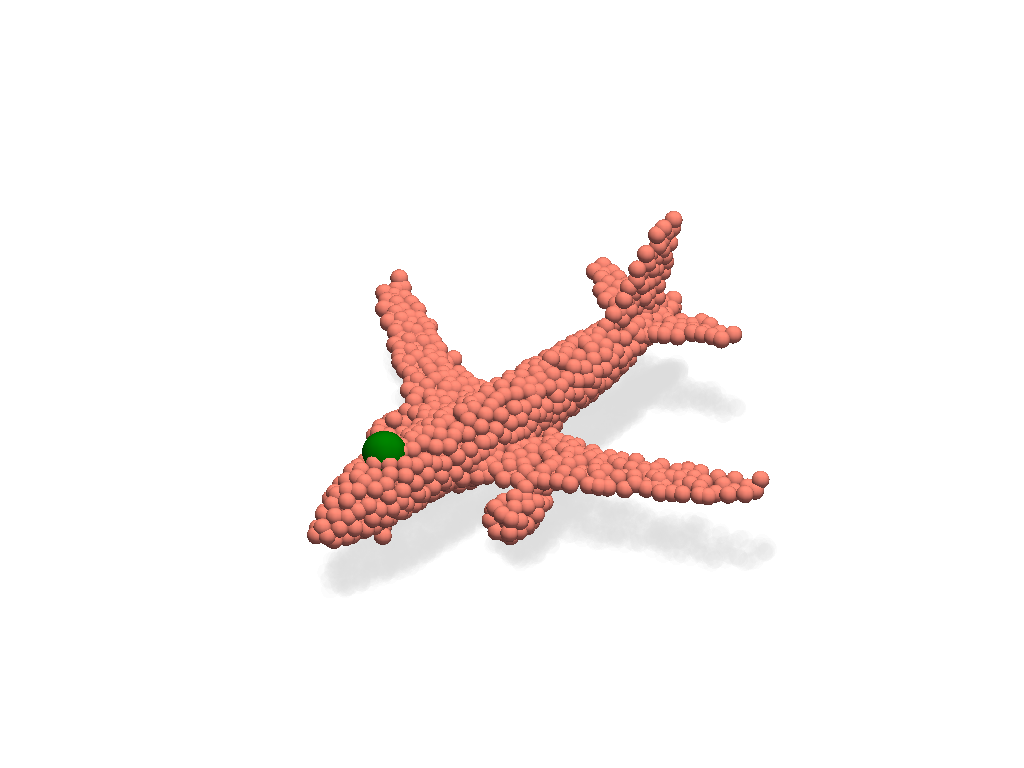

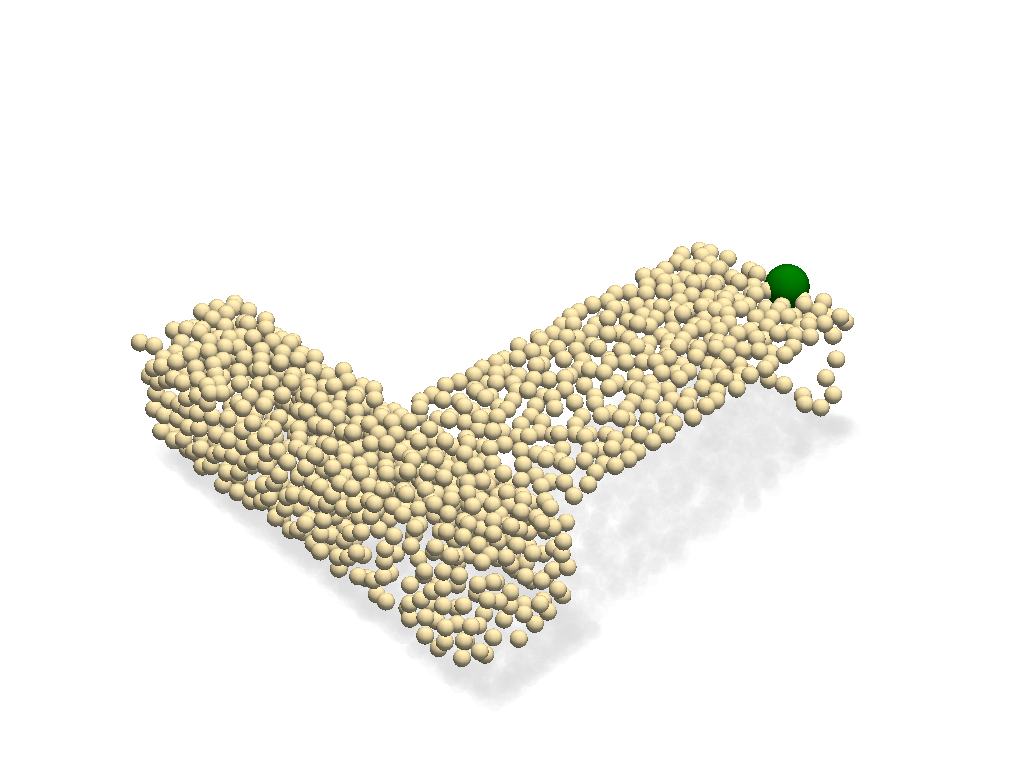

In [144]:
from matplotlib.colors import ListedColormap
s_color = np.array([255, 237, 188, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap2 = ListedColormap(color_map.transpose((1,0)))


# anc_idx = int(torch.multinomial(saliency[idx1], 1, replacement=True).reshape(-1))
xyz1, xyz2, s1,s2, x, weight, a1, a2 = mixsample(idx1,idx2, 0.5, 0.5, anc_idx=anc_idx)

plotter = pv.Plotter()
plotter.background_color = "W"

pos = xyz1[:,[0,2,1]].cpu().numpy()
point_cloud = pv.PolyData(pos)
point_cloud['y'] = s1.cpu().numpy()*0#**(3/4)
plotter.add_points(point_cloud, point_size=18, render_points_as_spheres=True, cmap=ListedColormap(cmap2.colors[::-1]))
anchor = pv.PolyData(a1[[0,2,1]].cpu().numpy())
plotter.add_points(anchor, point_size=45, render_points_as_spheres=True, color="g")
plotter.camera_position = camera_pos

plotter.camera_position = camera_pos
plotter.remove_scalar_bar()
light = pv.Light(intensity=0.15, shadow_attenuation = 0)
light.set_direction_angle(30,0)
plotter.add_light(light)
light = pv.Light(intensity=0.12, shadow_attenuation = 0)
light.set_direction_angle(30,180)
plotter.add_light(light)
get_shadow(plotter, pos, 18,5)
plotter.screenshot(filename='figs/xyz1.png')
plotter.show(screenshot='figs/xyz1.png', jupyter_backend="static")


plotter = pv.Plotter()
plotter.background_color = "W"

pos = xyz2[:,[0,2,1]].cpu().numpy()
point_cloud = pv.PolyData(pos)
point_cloud['y'] = s2.cpu().numpy()*0#**(3/4)
plotter.add_points(point_cloud, point_size=18, render_points_as_spheres=True, cmap=cmap2)
anchor = pv.PolyData(a2[[0,2,1]].cpu().numpy())
plotter.add_points(anchor, point_size=45, render_points_as_spheres=True, color="g")
plotter.camera_position = camera_pos
get_shadow(plotter, pos, 18,5)

plotter.camera_position = camera_pos
plotter.remove_scalar_bar()
light = pv.Light(intensity=0.15, shadow_attenuation = 0)
light.set_direction_angle(30,0)
plotter.add_light(light)
light = pv.Light(intensity=0.12, shadow_attenuation = 0)
light.set_direction_angle(30,180)
plotter.add_light(light)
plotter.screenshot(filename='figs/xyz2.png')
plotter.show(screenshot='figs/xyz2.png', jupyter_backend="static")

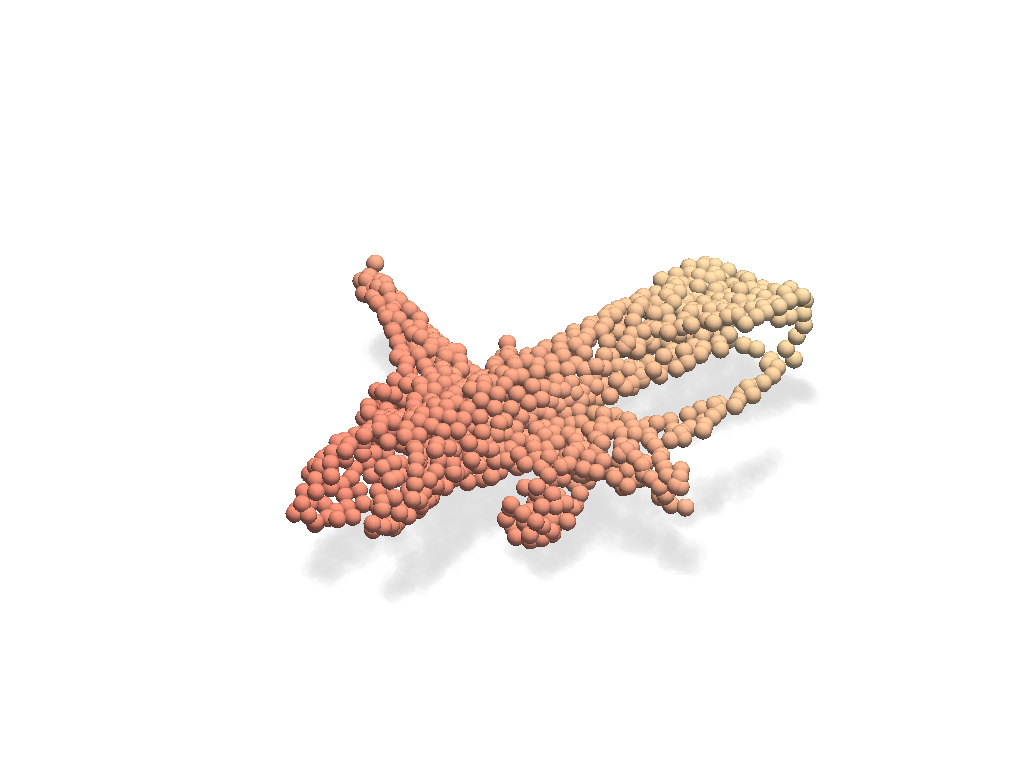

In [171]:
for sigma in [0.75]:
    alpha = 0.5
    xyz1, xyz2, s1,s2, x, weight,_,_ = mixsample(idx1,idx2, sigma = sigma, alpha = alpha, anc_idx = anc_idx)
    plotter = pv.Plotter(notebook=True)
    plotter.background_color = "W"

    pos = x[:,[0,2,1]].cpu().numpy()
    point_cloud = pv.PolyData(pos)
    point_cloud['y'] = weight[:,0].cpu().numpy()#**(3/4)
    plotter.add_points(point_cloud, point_size=18, render_points_as_spheres=True, cmap=cmap2, clim=[0,1])
    plotter.camera_position = camera_pos

    plotter.remove_scalar_bar()
    light = pv.Light(intensity=0.15, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)
    get_shadow(plotter, pos, 18,5)
    plotter.screenshot(filename='figs/sigma{}_alpha{}.png'.format(sigma,alpha))
    plotter.show(jupyter_backend="static")
    
# for alpha in [0.2, 0.5, 0.8]:
#     sigma=0.5
#     xyz1, xyz2, s1,s2, x, weight, _, _ = mixsample(idx1,idx2, sigma = sigma, alpha=alpha, anc_idx = anc_idx)
#     plotter = pv.Plotter(notebook=True)
#     plotter.background_color = "W"

#     pos = x[:,[0,2,1]].cpu().numpy()
#     point_cloud = pv.PolyData(pos)
#     point_cloud['y'] = weight[:,0].cpu().numpy()#**(3/4)
#     plotter.add_points(point_cloud, point_size=18, render_points_as_spheres=True, cmap=cmap2, clim=[0,1])
#     plotter.camera_position = camera_pos

#     plotter.remove_scalar_bar()
#     light = pv.Light(intensity=0.15, shadow_attenuation = 0)
#     light.set_direction_angle(30,0)
#     plotter.add_light(light)
#     light = pv.Light(intensity=0.12, shadow_attenuation = 0)
#     light.set_direction_angle(30,180)
#     plotter.add_light(light)
#     get_shadow(plotter, pos, 18,5)
#     plotter.screenshot(filename='figs/sigma{}_alpha{}.png'.format(sigma,alpha))
#     plotter.show(jupyter_backend="static")